**Лабораторная работа №8.** Рекуррентные нейронные сети для анализа временных рядов


1.   Загрузите данные. Изобразите ряд в виде графика. Вычислите основные характеристики временного ряда (сезонность, тренд, автокорреляцию).
2.   Для прогнозирования разделите временной ряд на обучающую, валидационную и контрольную выборки.
3.   Примените модель ARIMA для прогнозирования значений данного временного ряда.
4.   Повторите эксперимент по прогнозированию, реализовав рекуррентную нейронную сеть (с как минимум 2 рекуррентными слоями).
5.   Сравните качество прогноза моделей.



In [1]:
!pip install -q kaggle

import os
os.environ['KAGGLE_USERNAME'] = "awful1996" # username from the json file
os.environ['KAGGLE_KEY'] = "5e55f76a1cc7a4772bd7803cba8fb2c1" # key from the json file
#!kaggle datasets download -d iarunava/happy-house-dataset # api copied from kaggle
!kaggle datasets download -d robervalt/sunspots

  0% 0.00/22.4k [00:00<?, ?B/s]
100% 22.4k/22.4k [00:00<00:00, 40.9MB/s]


In [2]:
!unzip sunspots.zip

Archive:  sunspots.zip
  inflating: Sunspots.csv            


**Задание 1.**
Загрузите данные. Изобразите ряд в виде графика. Вычислите основные характеристики временного ряда (сезонность, тренд, автокорреляцию).


Using TensorFlow backend.


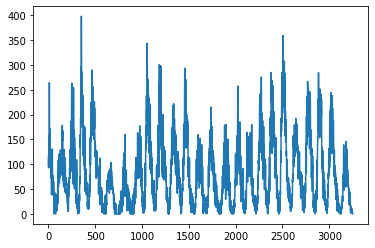

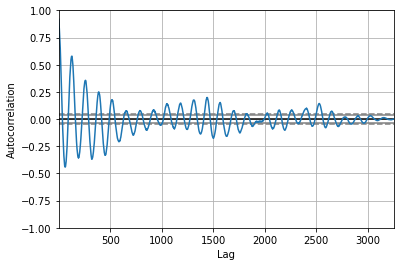

In [3]:
import pandas
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
import numpy
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


dataframe = pandas.read_csv('Sunspots.csv', usecols=[2], engine='python')
plt.plot(dataframe)
plt.show()

autocorrelation_plot(dataframe)

In [4]:
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

2276 976


**Задание 2.**
Для прогнозирования разделите временной ряд на обучающую, валидационную и контрольную выборки.


In [5]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
 
 # reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
#valX, valY = create_dataset(val, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(testY[:10])

[0.41511804 0.51130086 0.38849825 0.33626318 0.3239578  0.27071825
 0.45680562 0.49547967 0.42265195 0.40833753]


**Задание 3.**
Примените модель ARIMA для прогнозирования значений данного временного ряда.


In [0]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

X = dataframe.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)


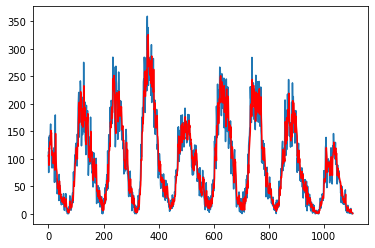

In [10]:
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

**Задание 4.**
Повторите эксперимент по прогнозированию, реализовав рекуррентную нейронную сеть (с как минимум 2 рекуррентными слоями).


In [7]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back), return_sequences=True))
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2)

Epoch 1/5
 - 17s - loss: 0.0134
Epoch 2/5
 - 16s - loss: 0.0048
Epoch 3/5
 - 15s - loss: 0.0048
Epoch 4/5
 - 16s - loss: 0.0048
Epoch 5/5
 - 15s - loss: 0.0048


In [8]:
# make predictions
trainPredict = model.predict(trainX)
print(trainPredict.shape)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
print(trainPredict.shape)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

(2274, 1)
(2274, 1)
Train Score: 27.04 RMSE
Test Score: 26.35 RMSE


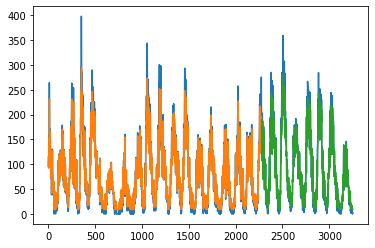

In [9]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()